<a href="https://colab.research.google.com/github/dannynacker/octAVEs/blob/main/octAVEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Omni Spectral Strobe Script ===
Enter the path to your audio file: /content/aaa_journey_1.mp3
Enter number of channels to extract (1, 2, 3, or 4): 4
Choose transposition direction: (0) Unison, (1) Up, (2) Down
Enter your choice: 2
Interval choices:
(0) Unison
(1) Minor Second
(2) Major Second
(3) Minor Third
(4) Major Third
(5) Perfect Fourth
(6) Tritone
(7) Perfect Fifth
(8) Minor Sixth
(9) Major Sixth
(10) Minor Seventh
(11) Major Seventh
(12) Octave
Choose interval (0-12): 4
Using transposition: MajorThird Down
Invert duty cycle? (y/n): n
Enter channel mapping mode: (1) 1 channel to all 4, (2) 2 channels, (4) All 4 channels: 4
Select device output:
 (1) SCCS (CSV output for MATLAB device)
 (2) RX1 (STP .txt file output)
Enter 1 or 2: 2
Enter desired output file name (without extension): pulses
Extracting spectral channels from audio...
CSV file 'pulses.csv' created with all transpositions and amplitude columns.
RX1 device selected. Converting CSV to STP format using selected tra

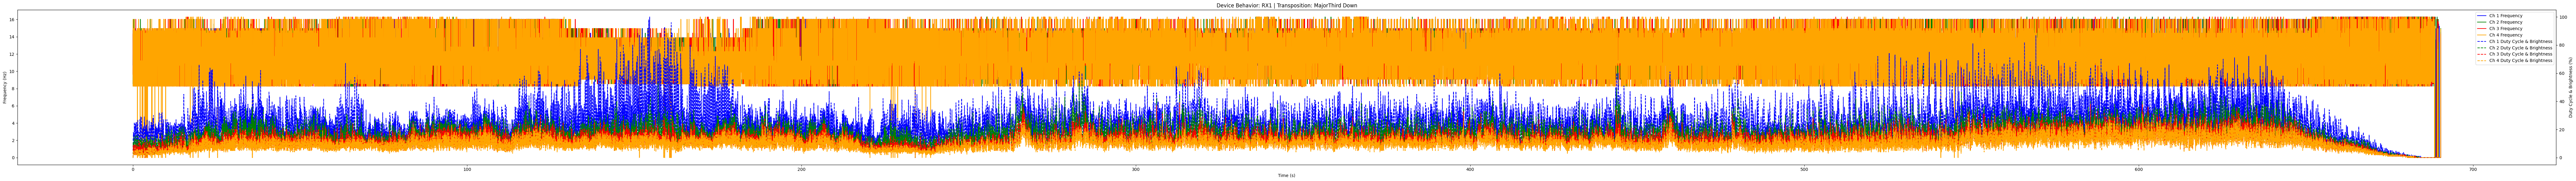

In [3]:
import numpy as np
import pandas as pd
import librosa
from scipy.signal import find_peaks
import math
import os
import matplotlib.pyplot as plt

##############################################################################
# 1) MUSICAL MAPPINGS & HELPER FUNCTIONS
##############################################################################

# Define musical intervals in semitones
intervals = {
    'Unison': 0,
    'Minor Second': 1,
    'Major Second': 2,
    'Minor Third': 3,
    'Major Third': 4,
    'Perfect Fourth': 5,
    'Tritone': 6,
    'Perfect Fifth': 7,
    'Minor Sixth': 8,
    'Major Sixth': 9,
    'Minor Seventh': 10,
    'Major Seventh': 11,
    'Octave': 12
}

# Note names and corresponding frequencies, from C-5 to B15
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
extended_frequencies = [
    0.51, 0.54, 0.58, 0.61, 0.65, 0.69, 0.73, 0.77, 0.82, 0.87, 0.92, 0.98,  # C-5 to B-5
    1.03, 1.09, 1.16, 1.22, 1.30, 1.38, 1.46, 1.54, 1.63, 1.73, 1.84, 1.95,  # C-4 to B-4
    2.06, 2.18, 2.31, 2.45, 2.60, 2.75, 2.92, 3.09, 3.27, 3.46, 3.67, 3.88,  # C-3 to B-3
    4.12, 4.36, 4.61, 4.88, 5.16, 5.45, 5.75, 6.17, 6.52, 6.89, 7.28, 7.69,  # C-2 to B-2
    8.18, 8.66, 9.18, 9.72, 10.30, 10.91, 11.56, 12.25, 12.98, 13.75, 14.57, 15.43,  # C-1 to B-1
    16.35, 17.32, 18.35, 19.45, 20.60, 21.83, 23.12, 24.50, 25.96, 27.50, 29.14, 30.87,  # C0 to B0
    32.70, 34.65, 36.71, 38.89, 41.20, 43.65, 46.25, 49.00, 51.91, 55.00, 58.27, 61.74,  # C1 to B1
    65.41, 69.30, 73.42, 77.78, 82.41, 87.31, 92.50, 98.00, 103.83, 110.00, 116.54, 123.47,  # C2 to B2
    130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00, 233.08, 246.94,  # C3 to B3
    261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,  # C4 to B4
    523.25, 554.37, 587.33, 622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77,  # C5 to B5
    1046.50, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.00, 1864.66, 1975.53,  # C6 to B6
    2093.00, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520.00, 3729.31, 3951.07,  # C7 to B7
    4186.01, 4434.92, 4698.63, 4978.03, 5274.04, 5587.65, 5919.91, 6271.93, 6644.88, 7040.00, 7458.62, 7902.13,  # C8 to B8
    8372.02, 8870.65, 9397.27, 9956.06, 10548.08, 11175.30, 11839.82, 12543.85, 13289.75, 14080.00, 14917.24, 15804.26,  # C9 to B9
    16744.04, 17741.29, 18794.55, 19912.13, 21096.16, 22350.61, 23679.64, 25087.71, 26579.50, 28160.00, 29834.48, 31608.53,  # C10 to B10
    33488.07, 35482.57, 37589.09, 39824.26, 42192.33, 44701.21, 47359.29, 50175.42, 53159.00, 56320.00, 59668.97, 63217.06,  # C11 to B11
    66976.14, 70965.14, 75178.18, 79648.52, 84384.66, 89402.41, 94718.57, 100350.84, 106318.00, 112640.00, 119337.94, 126434.13,  # C12 to B12
    133952.28, 141930.27, 150356.36, 159297.03, 168769.33, 178804.82, 189437.14, 200701.68, 212636.00, 225280.00, 238675.88, 252868.26,  # C13 to B13
    267904.55, 283860.55, 300712.72, 318594.05, 337538.66, 357609.63, 378874.29, 401403.36, 425272.00, 450560.00, 477351.76, 505736.53,  # C14 to B14
    535809.09, 567721.09, 601425.44, 637188.10, 675077.32, 715219.26, 757748.58, 802806.71, 850544.00, 901120.00, 954703.52, 1011473.06   # C15 to B15
];

# We'll use this array to scale extracted frequencies into the alpha band.
correspondingFreqArray = [8.18, 8.66, 9.18, 9.72, 10.30, 10.91, 11.56, 12.25, 12.98, 13.75, 14.57, 15.43, 16.36];

def find_note_and_deviation(freq, frequencies):
    """
    Finds the closest frequency in 'frequencies' to 'freq', returns the note name and deviation.
    """
    if freq <= 0:
        return "None", 0
    idx = (np.abs(np.array(frequencies) - freq)).argmin()
    closest_freq = frequencies[idx]
    deviation = freq - closest_freq
    note_index = idx % 12
    octave = idx // 12 - 1  # Adjust because our array starts at C-5
    note = note_names[note_index] + str(octave)
    return note, deviation

def scale_frequency_within_range(freq, correspondingFreqArray):
    """
    Scales 'freq' so that it lies within the min and max of correspondingFreqArray.
    """
    min_freq = min(correspondingFreqArray)
    max_freq = max(correspondingFreqArray)
    while freq < min_freq:
        freq *= 2
    while freq > max_freq:
        freq /= 2
    return freq

##############################################################################
# 2) FFT EXTRACTION FUNCTION (CSV Generation)
##############################################################################

def extract_channels(audio_path, channel_count):
    """
    Loads the audio file, computes the STFT, and extracts up to 'channel_count' distinct
    frequency peaks per time slice. For each candidate, it computes:
      - Base frequency scaled into the alpha band (Adjusted_Corr_Freq),
      - Raw amplitude,
      - Note and deviation,
      - And for each interval in 'intervals', both Up and Down transposed frequencies.
    Returns a DataFrame with columns:
      Time, Adjusted_Corr_Freq_i, Amplitude_i, Note_i, Deviation_i,
      and for each interval key (with spaces removed): "<key>_Up_Freq_i", "<key>_Down_Freq_i" for i = 1..channel_count.
    """
    y, sr = librosa.load(audio_path, sr=None)
    stft = np.abs(librosa.stft(y))
    frequencies_stft = librosa.fft_frequencies(sr=sr)
    times = np.linspace(0, len(y)/sr, stft.shape[1])

    results = []
    for t_idx, spectrum in enumerate(stft.T):
        time_val = times[t_idx]
        peak_indices, _ = find_peaks(spectrum, height=np.max(spectrum)*0.1)
        if len(peak_indices) == 0:
            peak_indices = [np.argmax(spectrum)]
        sorted_indices = sorted(peak_indices, key=lambda x: spectrum[x], reverse=True)
        selected_freqs = []
        selected_amps = []
        selected_notes = []
        selected_devs = []
        for idx in sorted_indices:
            freq_candidate = frequencies_stft[idx]
            if len(selected_freqs) == 0 or all(abs(freq_candidate - f) > 1 for f in selected_freqs):
                selected_freqs.append(freq_candidate)
                selected_amps.append(spectrum[idx])
                note, dev = find_note_and_deviation(freq_candidate, extended_frequencies)
                selected_notes.append(note)
                selected_devs.append(dev)
            if len(selected_freqs) >= channel_count:
                break
        while len(selected_freqs) < channel_count:
            selected_freqs.append(0)
            selected_amps.append(0)
            selected_notes.append("None")
            selected_devs.append(0)
        row_dict = {"Time": time_val}
        for ch in range(channel_count):
            raw_freq = selected_freqs[ch]
            if raw_freq > 0:
                base_freq = scale_frequency_within_range(raw_freq, correspondingFreqArray)
            else:
                base_freq = 0
            row_dict[f"Adjusted_Corr_Freq_{ch+1}"] = base_freq
            row_dict[f"Amplitude_{ch+1}"] = selected_amps[ch]
            row_dict[f"Note_{ch+1}"] = selected_notes[ch]
            row_dict[f"Deviation_{ch+1}"] = selected_devs[ch]
            for key, semitones in intervals.items():
                col_key = key.replace(" ", "")
                ratio_up = 2 ** (semitones/12)
                ratio_down = 2 ** (-semitones/12)
                if base_freq > 0:
                    trans_up = scale_frequency_within_range(base_freq * ratio_up, correspondingFreqArray)
                    trans_down = scale_frequency_within_range(base_freq * ratio_down, correspondingFreqArray)
                else:
                    trans_up = 0
                    trans_down = 0
                row_dict[f"{col_key}_Up_Freq_{ch+1}"] = trans_up
                row_dict[f"{col_key}_Down_Freq_{ch+1}"] = trans_down
        results.append(row_dict)
    df = pd.DataFrame(results)
    return df, sr

##############################################################################
# 3) AMPLITUDE SCALING FUNCTION
##############################################################################

def scale_amplitudes_in_df(df, channel_count):
    """
    Scales the raw amplitude values so that the maximum across all channels becomes 255 (for SCCS),
    and creates separate columns for RX1 by scaling to 0-100.
    """
    all_amp = pd.concat([df[f"Amplitude_{ch}"] for ch in range(1, channel_count+1)])
    global_max = all_amp.max()
    for ch in range(1, channel_count+1):
        df[f"Amplitude_SCCS_{ch}"] = (df[f"Amplitude_{ch}"] / global_max * 255).round().astype(int)
        df[f"Amplitude_RX1_{ch}"] = (df[f"Amplitude_SCCS_{ch}"] * 100.0 / 255).round().astype(int)
    return df

##############################################################################
# 4) STP FILE CONVERSION FUNCTIONS (for RX1 device)
##############################################################################

def format_time(total_seconds):
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    fraction = total_seconds - int(total_seconds)
    return f"{hours:02}:{minutes:02}:{seconds:02}.{int(fraction*10)}"

def get_led_assignments():
    return [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]

def format_stp_line(step_duration, wave_type, osc_params):
    led_assign = get_led_assignments()
    blocks = []
    for i in range(4):
        p = osc_params[i]
        block = (f"{wave_type},"
                 f"{p['freq_start']:.2f},"
                 f"{p['freq_end']:.2f},"
                 f"{int(round(p['duty_start']))},"
                 f"{int(round(p['duty_end']))},"
                 f"{','.join(str(x) for x in led_assign[i])},"
                 f"{int(round(p['lum_start']))},"
                 f"{int(round(p['lum_end']))}")
        blocks.append(block)
    return f"STP\"{step_duration:.1f},{','.join(blocks)}\""

def find_time_index(time_array, t):
    candidates = np.where(time_array >= t)[0]
    if len(candidates) == 0:
        return len(time_array) - 1
    return candidates[0]

def create_stp_from_df(df, invert_duty, freq_field_prefix, amp_field_prefix="Amplitude_RX1", out_name="output_stp"):
    """
    Converts the CSV data to an STP file using 100ms steps.
    For each 100ms slice, the function uses the frequency and amplitude values
    from that timeslice as both the start and end values (since the device
    cannot interpolate across such a small step).
    """
    time_array = df["Time"].values
    nChannels = 4
    song_length = time_array[-1]
    step_duration = 0.1  # 100ms steps
    num_steps = int(math.floor(song_length / step_duration))
    stp_lines = []
    wave_type = 1  # Square wave

    for step in range(num_steps):
        current_time = step * step_duration
        idx = find_time_index(time_array, current_time)
        osc_params = []
        for ch in range(1, nChannels+1):
            freq_val = df[f"{freq_field_prefix}_{ch}"].iloc[idx]
            amp_val = df[f"{amp_field_prefix}_{ch}"].iloc[idx]
            freq_val = round(freq_val, 2)
            amp_val = round(amp_val)
            lum_val = min(100, max(0, int(amp_val)))
            if invert_duty:
                duty_val = 100 - lum_val
            else:
                duty_val = lum_val
            # Use the same value for both start and end since interpolation is not desired.
            osc_params.append({
                "freq_start": freq_val,
                "freq_end": freq_val,
                "duty_start": duty_val,
                "duty_end": duty_val,
                "lum_start": lum_val,
                "lum_end": lum_val
            })
        line = format_stp_line(step_duration, wave_type, osc_params)
        stp_lines.append(line)

    total_time = num_steps * step_duration
    stp_output = []
    stp_output.append(f'TIM\"{format_time(total_time)}\"')
    stp_output.append(f'DUR\"{total_time:.1f}\"')
    stp_output.extend(stp_lines)
    stp_filename = f"{out_name}.txt"
    with open(stp_filename, "w", newline="\r\n", encoding="utf-8") as f:
        f.write("\r\n".join(stp_output))
    print(f"STP file '{stp_filename}' created with {len(stp_lines)} steps.")
    return stp_filename

##############################################################################
# 5) PLOTTING FUNCTION
##############################################################################

def plot_behavior(df, invert_duty, device_choice, transposition_label):
    """
    Plots behavior:
      - Left y-axis: Frequency (using the selected transposition frequency columns)
      - Right y-axis: Duty cycle and Brightness (using Amplitude_RX1 columns scaled to 0-100).
        If duty inversion is enabled, both inverted duty cycle and raw brightness are shown.
    """
    time_vals = df["Time"].values
    colors = ["blue", "green", "red", "orange"]

    plt.figure(figsize=(84, 6))
    ax1 = plt.gca()
    if transposition_label == "Unison":
        freq_field = "Adjusted_Corr_Freq"
    else:
        freq_field = transposition_label.replace(" ", "_") + "_Freq"
    for ch in range(1, 5):
        freq = df[f"{freq_field}_{ch}"].values
        ax1.plot(time_vals, freq, label=f"Ch {ch} Frequency", color=colors[ch-1])
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frequency (Hz)")

    ax2 = ax1.twinx()
    for ch in range(1, 5):
        amp = df[f"Amplitude_RX1_{ch}"].values
        duty = np.array(amp)  # Already 0-100
        if invert_duty:
            inverted_duty = 100 - duty
            ax2.plot(time_vals, inverted_duty, label=f"Ch {ch} Inverted Duty", linestyle="--", color=colors[ch-1])
            ax2.plot(time_vals, duty, label=f"Ch {ch} Brightness", linestyle=":", color=colors[ch-1])
        else:
            ax2.plot(time_vals, duty, label=f"Ch {ch} Duty Cycle & Brightness", linestyle="--", color=colors[ch-1])
    ax2.set_ylabel("Duty Cycle & Brightness (%)")

    device_label = "SCCS" if device_choice == 1 else "RX1"
    plt.title(f"Device Behavior: {device_label} | Transposition: {transposition_label}")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc="best")

    plt.tight_layout()
    plt.show()

##############################################################################
# 6) MAIN OMNI SCRIPT
##############################################################################

def main():
    print("=== Omni Spectral Strobe Script ===")
    # -- Audio & Extraction Parameters --
    audio_path = input("Enter the path to your audio file: ").strip()
    try:
        channel_count = int(input("Enter number of channels to extract (1, 2, 3, or 4): "))
    except:
        channel_count = 4
    if channel_count not in [1, 2, 3, 4]:
        print("Invalid input. Defaulting to 4 channels.")
        channel_count = 4

    print("Choose transposition direction: (0) Unison, (1) Up, (2) Down")
    try:
        direction_choice = int(input("Enter your choice: "))
    except:
        direction_choice = 0
    if direction_choice not in [0, 1, 2]:
        direction_choice = 0

    intervals_list = ["Unison", "Minor Second", "Major Second", "Minor Third", "Major Third",
                      "Perfect Fourth", "Tritone", "Perfect Fifth", "Minor Sixth", "Major Sixth",
                      "Minor Seventh", "Major Seventh", "Octave"]
    print("Interval choices:")
    for i, name in enumerate(intervals_list):
        print(f"({i}) {name}")
    try:
        interval_choice = int(input("Choose interval (0-12): "))
    except:
        interval_choice = 0
    if interval_choice < 0 or interval_choice > 12:
        interval_choice = 0

    if interval_choice == 0:
        transposition_label = "Unison"
    else:
        dirStr = "Up" if direction_choice == 1 else "Down"
        intervalName = intervals_list[interval_choice].replace(" ", "")
        transposition_label = f"{intervalName} {dirStr}"
    print(f"Using transposition: {transposition_label}")

    # -- Duty Cycle Inversion --
    invert_choice = input("Invert duty cycle? (y/n): ").strip().lower()
    invert_duty = (invert_choice == "y")

    # -- Channel Mapping Mode --
    mapping_mode = int(input("Enter channel mapping mode: (1) 1 channel to all 4, (2) 2 channels, (4) All 4 channels: "))
    if mapping_mode not in [1, 2, 4]:
        raise ValueError("Invalid mapping mode. Choose 1, 2, or 4.")

    # -- Device Selection --
    print("Select device output:")
    print(" (1) SCCS (CSV output for MATLAB device)")
    print(" (2) RX1 (STP .txt file output)")
    try:
        device_choice = int(input("Enter 1 or 2: "))
    except:
        device_choice = 1

    # -- Output File Name --
    out_name = input("Enter desired output file name (without extension): ").strip()
    if out_name == "":
        out_name = "multi_spectra_output"

    # --- Spectral Extraction ---
    print("Extracting spectral channels from audio...")
    df, sr = extract_channels(audio_path, channel_count)
    df = scale_amplitudes_in_df(df, channel_count)

    # --- Duplicate channels to fill 4 oscillator slots according to mapping mode ---
    if mapping_mode == 1:
        for ch in range(2, 5):
            df[f"Adjusted_Corr_Freq_{ch}"] = df["Adjusted_Corr_Freq_1"]
            df[f"Amplitude_{ch}"] = df["Amplitude_1"]
            df[f"Amplitude_SCCS_{ch}"] = df["Amplitude_SCCS_1"]
            df[f"Amplitude_RX1_{ch}"] = df["Amplitude_RX1_1"]
            df[f"Note_{ch}"] = df["Note_1"]
            df[f"Deviation_{ch}"] = df["Deviation_1"]
            for key in intervals_list:
                col_up = f"{key.replace(' ', '')}_Up_Freq_1"
                col_down = f"{key.replace(' ', '')}_Down_Freq_1"
                if col_up in df.columns:
                    df[f"{key.replace(' ', '')}_Up_Freq_{ch}"] = df[col_up]
                else:
                    df[f"{key.replace(' ', '')}_Up_Freq_{ch}"] = 0
                if col_down in df.columns:
                    df[f"{key.replace(' ', '')}_Down_Freq_{ch}"] = df[col_down]
                else:
                    df[f"{key.replace(' ', '')}_Down_Freq_{ch}"] = 0
    elif mapping_mode == 2:
        df["Adjusted_Corr_Freq_3"] = df["Adjusted_Corr_Freq_2"]
        df["Adjusted_Corr_Freq_4"] = df["Adjusted_Corr_Freq_2"]
        df["Amplitude_3"] = df["Amplitude_2"]
        df["Amplitude_4"] = df["Amplitude_2"]
        df["Amplitude_SCCS_3"] = df["Amplitude_SCCS_2"]
        df["Amplitude_SCCS_4"] = df["Amplitude_SCCS_2"]
        df["Amplitude_RX1_3"] = df["Amplitude_RX1_2"]
        df["Amplitude_RX1_4"] = df["Amplitude_RX1_2"]
        df["Note_3"] = df["Note_2"]
        df["Note_4"] = df["Note_2"]
        df["Deviation_3"] = df["Deviation_2"]
        df["Deviation_4"] = df["Deviation_2"]
        for key in intervals_list:
            col_up = f"{key.replace(' ', '')}_Up_Freq_2"
            col_down = f"{key.replace(' ', '')}_Down_Freq_2"
            if col_up in df.columns:
                df[f"{key.replace(' ', '')}_Up_Freq_3"] = df[col_up]
                df[f"{key.replace(' ', '')}_Up_Freq_4"] = df[col_up]
            else:
                df[f"{key.replace(' ', '')}_Up_Freq_3"] = 0
                df[f"{key.replace(' ', '')}_Up_Freq_4"] = 0
            if col_down in df.columns:
                df[f"{key.replace(' ', '')}_Down_Freq_3"] = df[col_down]
                df[f"{key.replace(' ', '')}_Down_Freq_4"] = df[col_down]
            else:
                df[f"{key.replace(' ', '')}_Down_Freq_3"] = 0
                df[f"{key.replace(' ', '')}_Down_Freq_4"] = 0
    # mapping_mode == 4: no duplication needed.

    csv_filename = f"{out_name}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"CSV file '{csv_filename}' created with all transpositions and amplitude columns.")

    # --- Device-Specific Output ---
    if device_choice == 1:
        print("SCCS device selected. Use the generated CSV for your MATLAB SCCS workflow.")
    elif device_choice == 2:
        print("RX1 device selected. Converting CSV to STP format using selected transposition columns...")
        if transposition_label == "Unison":
            selected_freq_prefix = "Adjusted_Corr_Freq"
        else:
            selected_freq_prefix = transposition_label.replace(" ", "_") + "_Freq"
        stp_filename = create_stp_from_df(df, invert_duty, freq_field_prefix=selected_freq_prefix, amp_field_prefix="Amplitude_RX1", out_name=out_name + "_stp")
        print(f"STP file '{stp_filename}' created for RX1 device.")
    else:
        print("Invalid device choice. Exiting.")

    # --- Plotting Behavior ---
    plot_behavior(df, invert_duty, device_choice, transposition_label)

if __name__ == "__main__":
    main()